<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Fly Ventral Nerve Cord Connectomics Tutorial 

This tutorial provides an introduction to accessing and analyzing a connectomics dataset of the female adult nerve cord (FANC) in the fruit fly. You can learn more about the FANC dataset __[here](https://connectomics.hms.harvard.edu/project1)__. The full dataset can be accessed through Connectome Annotation Versioning Engine (CAVE), a platform that supports large-scale connectomics datasets. More information on CAVE can be found here: __[github]( https://github.com/CAVEconnectome)__, __[preprint](https://www.biorxiv.org/content/10.1101/2023.07.26.550598v1)__. <br> 
    
The FANC dataset is still in production mode and requires a CAVE account and permissions to access. In this tutorial, we will work with a small part of the dataset. Link to download __[data](https://github.com/leesuyee/vnc_connectomics_tutorial/tree/main)__. Specifically, we will investigate the connectivity and circuitry of leg somatosensory neurons in the fruit fly. 
    
#### Learning Objectives: 

1. Introduction to FANC dataset
2. Perform basic queries of neurons of interest (e.g. find presynaptic and postsynaptic partners) 
3. Generate connectivity matrices 
4. Reference cell type information in annotation tables 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Introduction 

#### Exploring the Female Adult Nerve Cord (FANC) dataset in neuroglancer 
    
We will focus on a dataset from reconstructed femoral chordotonal (FeCO) sensory axons in the front, left leg of the fruit fly and their postsynaptic partners (threshold of 3 synaptic connections). The FeCO is the largest proprioceptive organ in the fruit fly leg and detects position, movement, and vibration of the leg. There are 152 FeCO neurons in one of the front legs - the cell body is located in the femur of the leg and sends and axon projection to the ventral nerve cord. This sensory information feeds back onto motor circuits to inform behaviors such as walking and postural control. 
    

    
In FANC, there are 80 FeCO axons that have been reconstructed in the front, left leg. You can view the neurons in this dataset using __[neuroglancer](https://github.com/google/neuroglancer)__, a web platform for visualizing EM datasets and reconstructed neurons. 


There are five distinct cell types named for their distinct morphological features (claw, hook, club) and functional features (tuned to leg extension or leg flexion). Click the links to view the reconstructed sensory axons in neuroglancer. 

1. __[claw extension](https://neuromancer-seung-import.appspot.com/?json_url=https://raw.githubusercontent.com/sagrawal/Lee_2024/main/jsons/clawE.json)__  (position) 

2. __[claw flexion](https://neuromancer-seung-import.appspot.com/?json_url=https://raw.githubusercontent.com/sagrawal/Lee_2024/main/jsons/clawF.json)__  (position) 

3. __[hook extension](https://neuromancer-seung-import.appspot.com/?json_url=https://raw.githubusercontent.com/sagrawal/Lee_2024/main/jsons/hookE.json)__  (movement) 

4. __[hook flexion](https://neuromancer-seung-import.appspot.com/?json_url=https://raw.githubusercontent.com/sagrawal/Lee_2024/main/jsons/hookF.json)__  (movement) 


5. __[club](https://neuromancer-seung-import.appspot.com/?json_url=https://raw.githubusercontent.com/sagrawal/Lee_2024/main/jsons/clubs.json)__  (movement and vibration) 


Neurons postsynaptic to FeCO neurons 
__[postsynaptic neurons](https://neuromancer-seung-import.appspot.com/?json_url=https://raw.githubusercontent.com/sagrawal/Lee_2024/main/jsons/all_downstream.json)__


#### Programmatically accessing the dataset 

Automated synapse detection was applied to the entire FANC dataset. We can query the position of every synapse and identify neurons that are synaptically connected to build synapse-level wiring diagrams. We will work with a synapse table of the FeCO sensory axons, in other words, a table containing the annotations for every synapse a FeCO neuron makes with a postsynaptic partner. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import the relevant python libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 

%config InlineBackend.figure_format = 'retina' # retina display mode to make figures crisp 


In [2]:
# import the csvs as dataframes 

# FeCO sensory neuron synapse table 
synapse_df = pd.read_csv("synapse_df.csv")

# Annotation tables to reference cell type information 
feco_df_all = pd.read_csv("feco_df_all.csv") # cell type information for FeCO sensory axons 
downstream_feco_axons = pd.read_csv("downstream_feco_axons.csv") # cell type information for postsynaptic partners of FeCO 

# Bonus annotation table 
mn_df = pd.read_csv("mn_df.csv") # cell type information for leg motor neurons 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Dataset Description

We will primarily work with synapse_df: a dataframe that contains information on all of the synaptic connections between the FeCO sensory axons and their downstream partners. Each row represents a synaptic connection between a presynaptic neuron (pre_pt_root_id) and a postsynaptic neuron (post_pt_root_id). 
  
    

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>id for this synapse annotation</td>
    </tr>
    <tr>
        <td>pre_pt_supervoxel_id</td>
        <td>a bookkeeping column for the presynaptic side </td>
    </tr>
    <tr>
        <td>pre_pt_root_id</td>
        <td>id for the pre synaptic neuron</td>
    </tr>
    <tr>
        <td>post_pt_supervoxel_id</td>
        <td>Same bookkeeping column as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>post_pt_root_id</td>
        <td>Same as pre_pt but for the post synaptic side</td>
    </tr>
    <tr>
        <td>score</td>
        <td>The size of the synaptic cleft in units of 4.3,4.3,45 voxels.</td>
    </tr>
    <tr>
        <td>pre_pt_position</td>
        <td>a point that is in the pre-synaptic terminal of this synapse (in voxels) </td>
    </tr>
    <tr>
        <td>post_pt_position</td>
        <td>Same as pre_pt but for the post synaptic side.</td>
    </tr>

</table>

In [3]:
synapse_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,created,superceded_id,valid,score,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position
0,0,0,0,12347226,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72553681551362367,648518346508752447,72553681551364124,648518346496052070,[ 15711 104803 3127],[ 15725 104811 3129]
1,1,1,1,42127599,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72342781074735265,648518346480125925,72342781074737829,648518346502617767,[ 9275 110693 2403],[ 9251 110663 2404]
2,2,2,5,42127607,2022-11-17 14:28:59.843347+00:00,NaN,t,24,72342781074723555,648518346480125925,72342781074721267,648518346489767549,[ 9281 110705 2398],[ 9257 110693 2397]
3,3,3,9,42127880,2022-11-17 14:28:59.843347+00:00,NaN,t,19,72342781074677182,648518346480666625,72342781074669821,648518346489566297,[ 9535 110905 2377],[ 9537 110885 2376]
4,4,4,10,42127679,2022-11-17 14:28:59.843347+00:00,NaN,t,26,72342781074751920,648518346480125925,72342781074771140,648518346489566297,[ 9325 110663 2408],[ 9323 110625 2409]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21911,22315,22315,56524,40344360,2022-11-17 14:28:59.843347+00:00,NaN,t,16,72413149953082217,648518346499722309,72413149953074702,648518346502916595,[ 10875 112293 2636],[ 10839 112307 2636]
21912,22316,22316,56526,40514891,2022-11-17 14:28:59.843347+00:00,NaN,t,26,73469299658386692,648518346478788180,73469299658387038,648518346474435437,[ 42003 130737 2820],[ 42027 130751 2819]
21913,22317,22317,56530,40553999,2022-11-17 14:28:59.843347+00:00,NaN,t,57,72623706563962620,648518346487912272,72623706563955920,648518346490196954,[17855 95375 2861],[17823 95369 2862]
21914,22318,22318,56531,40554000,2022-11-17 14:28:59.843347+00:00,NaN,t,46,72623706563962620,648518346487912272,72623706563955958,648518346499593822,[17851 95389 2860],[17821 95399 2860]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Basic Queries 

Let's look at one sensory neuron in pre_pt_root_id and query some basic features: <br> 
    1. number of synapses <br> 
    2. number of unique postsynaptic partners <br> 
    3. top postsynaptic partners

#### Task: 
Create a dataframe with only the connections downstream of a single sensory neuron of interest (pre_pt_root_id). 

In [4]:
neuron_id = 648518346474593218
single_synapse_df = synapse_df[synapse_df.pre_pt_root_id == neuron_id]

single_synapse_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,created,superceded_id,valid,score,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position
14,14,14,31,42168006,2022-11-17 14:28:59.843347+00:00,NaN,t,19,72624050295556513,648518346474593218,72624050295561555,648518346472722185,[ 17945 105819 3119],[ 17931 105789 3119]
31,31,31,91,42167745,2022-11-17 14:28:59.843347+00:00,NaN,t,25,72624050295644836,648518346474593218,72624050295664156,648518346381470813,[ 17605 106115 3156],[ 17579 106109 3158]
36,36,36,102,42167752,2022-11-17 14:28:59.843347+00:00,NaN,t,14,72624050295606125,648518346474593218,72624050295597995,648518346381470813,[ 17615 105989 3135],[ 17583 106001 3134]
39,39,39,111,42167936,2022-11-17 14:28:59.843347+00:00,NaN,t,17,72624050295630881,648518346474593218,72624050295640122,648518346484246823,[ 17835 106131 3148],[ 17809 106151 3150]
44,44,44,136,42167762,2022-11-17 14:28:59.843347+00:00,NaN,t,19,72624050295618711,648518346474593218,72624050295606169,648518346484246823,[ 17615 106011 3135],[ 17599 106033 3134]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21523,21922,21922,55536,20451517,2022-11-17 14:28:59.843347+00:00,NaN,t,27,72413150020343830,648518346474593218,72413150020370246,648518346508092214,[ 11893 111471 2817],[ 11913 111445 2818]
21573,21972,21972,55651,24463469,2022-11-17 14:28:59.843347+00:00,NaN,t,27,72905456485787063,648518346474593218,72905456485789432,648518346494799159,[ 26417 103911 3026],[ 26389 103887 3026]
21575,21974,21974,55654,24463479,2022-11-17 14:28:59.843347+00:00,NaN,t,22,72905456485787063,648518346474593218,72905456485801979,648518346492104815,[ 26425 103915 3026],[ 26409 103889 3028]
21576,21975,21975,55655,24463470,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72905456485787063,648518346474593218,72905456485794562,648518346472653065,[ 26413 103931 3025],[ 26389 103917 3028]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Task: 
How many synapses does this sensory neuron have? 

In [5]:
len(single_synapse_df)

247

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Task: 
How many neurons are downstream of this sensory neuron? 

In [6]:
len(single_synapse_df.post_pt_root_id.unique())

42

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


What are the top 10 postsynaptic partners? <br>
    
Neurons typically make multiple synapses onto each other. The more synapses that connect a pair of neurons, the stronger the strength of their connection. In synapse_df, each row represents a single synaptic connection, so many of the rows are redundant. We can count the redundant rows to quantify the number of synapses between connected neurons and resort the dataframe to identify the top downstream partners. 
<br><br>

In [5]:
# this code will count the number of synapses between presynaptic and postsynaptic partners 
# the logic is as follows: 
# 1. groupby counts the number of rows with the same pre_pt_root_id and post_pt_root_id 
# 2. reset_index creates a new column called "number_of_synapses" with the counted rows 
# 3. sort_values will reorganize the dataframe by the defined column 
# 4. reset_index(drop = True) again will drop the index 

single_syn_per_conn = single_synapse_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count()\
                     .reset_index(name="number_of_synapses")\
                     .sort_values(by=['number_of_synapses'], ascending=False)\
                     .reset_index(drop=True)

# Look at the first 10 rows
single_syn_per_conn[0:10]

,pre_pt_root_id,post_pt_root_id,number_of_synapses
0,648518346474593218,648518346507389983,22
1,648518346474593218,648518346531401754,21
2,648518346474593218,648518346472722185,18
3,648518346474593218,648518346502916595,15
4,648518346474593218,648518346475527296,15
5,648518346474593218,648518346497743606,11
6,648518346474593218,648518346492104815,10
7,648518346474593218,648518346500132614,9
8,648518346474593218,648518346503120371,7
9,648518346474593218,648518346481205338,7


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Task: 
View the top 10 partners in neuroglancer <br> 

Let's look at the anatomy of the top 10 partners in neuroglancer. Copy the neuron ids (segment IDs) and paste them into the right hand bar in neuroglancer to look at the anatomy of the downstream partners. 
    
__[Neuroglancer link to view postsynaptic neurons (public view).](https://neuromancer-seung-import.appspot.com/?json_url=https://raw.githubusercontent.com/sagrawal/Lee_2024/main/jsons/all_downstream.json)__

Notes: Use the blue check box above the ids to toggle the view of neurons on/off. Paste the ids of interest into the white box to toggle the view of the relevant neurons on.


In [6]:
single_syn_per_conn.post_pt_root_id.tolist()[0:10]

[648518346507389983,
 648518346531401754,
 648518346472722185,
 648518346502916595,
 648518346475527296,
 648518346497743606,
 648518346492104815,
 648518346500132614,
 648518346503120371,
 648518346481205338]

#### Distribution of the number of synapses 

Now that we know how to query the number of synapses of a single neuron, let's look at the distribution of the number of synapses for all of the sensory neurons in the dataset. 


Text(0.5, 0, 'number of synapses')

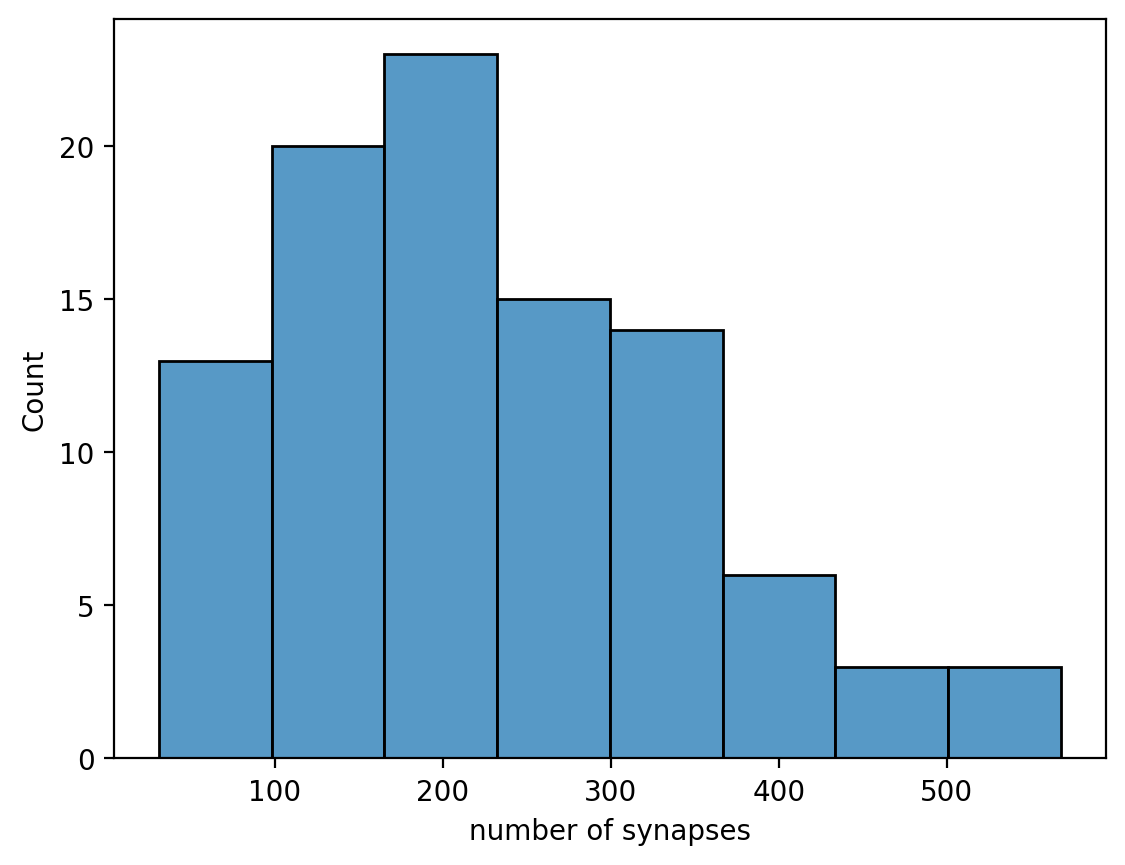

In [7]:
synapse_counts = [] 

for idx in synapse_df.pre_pt_root_id.unique().tolist(): # iterate through all of the unique pre_pt_root_ids 
    synapse_counts.append(len(synapse_df[synapse_df.pre_pt_root_id == idx])) # calculate and append the number of synapses for each pre_pt_root_id 
    
# plot the distribution using histplot 
sns.histplot(synapse_counts) 
plt.xlabel('number of synapses')



#### Distribution of the number of downstream partners 

#### Task: 

repeat as before but plot the distribution of the number of unique partners downstream of FeCO sensory neurons

Text(0.5, 0, 'number of synapses')

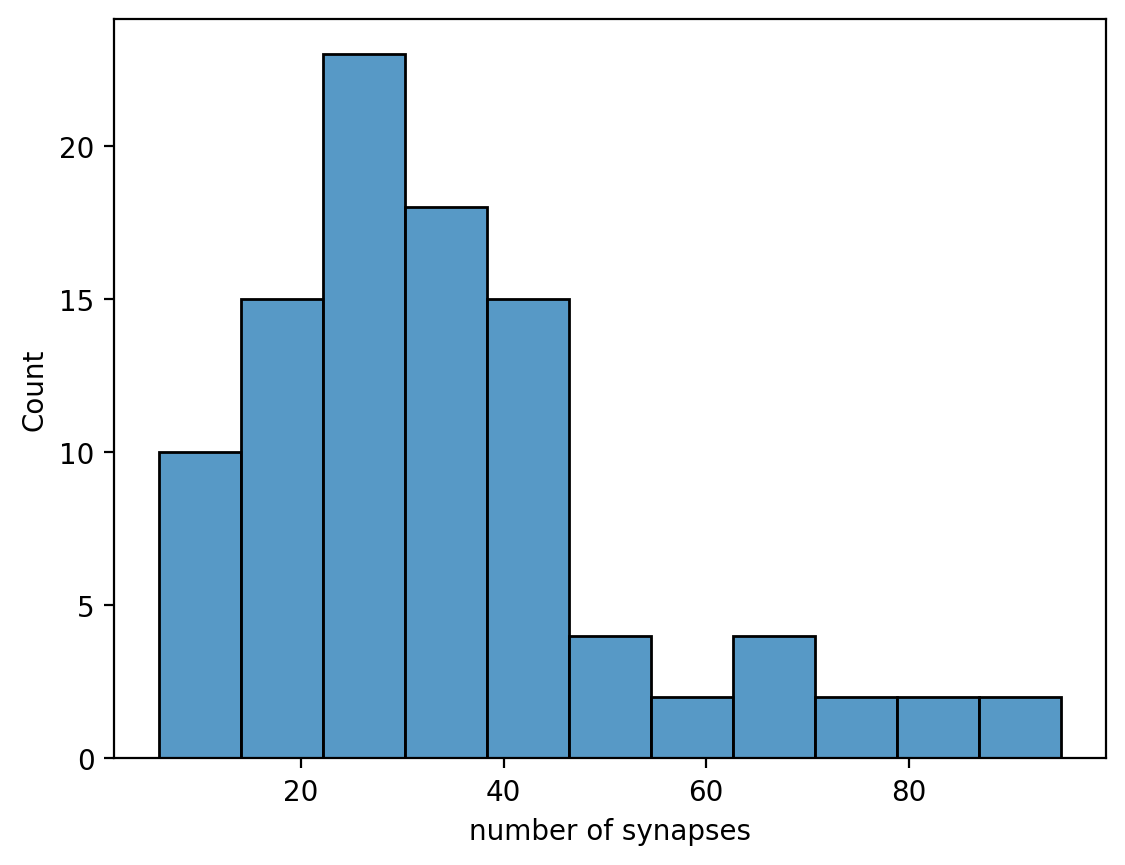

In [8]:
partner_counts = [] 

for idx in synapse_df.pre_pt_root_id.unique().tolist(): # iterate through all of the unique pre_pt_root_ids 
    partner_counts.append(len(synapse_df[synapse_df.pre_pt_root_id == idx].post_pt_root_id.unique())) # calculate and append the number of synapses for each pre_pt_root_id 
    
# plot the distribution using histplot 
sns.histplot(partner_counts) 
plt.xlabel('number of synapses')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Generate a connectivity matrix 

Let's look at the connectivity between all of the presynaptic sensory neurons and their postsynaptic partners. The following code will generate a connectivity matrix, quantifying the number of synapses between the presynaptic neurons (pre_pt_root_id) and postsynaptic neurons (post_pt_root_id). We can plot the connectivity matrix as a heatmap. 

In [9]:
#crosstab will count the number of redundant rows and generate a matrix with 
# pre_pt_root_ids as the rows and post_pt_root_ids as the columns 

conn_mat = pd.crosstab(synapse_df['pre_pt_root_id'],synapse_df['post_pt_root_id']) 
conn_mat


post_pt_root_id,648518346342398886,648518346342615863,648518346343026776,648518346343047173,648518346344474710,648518346345678569,648518346345690089,648518346345860384,648518346345980192,648518346346019534,...,648518346524147717,648518346524171525,648518346524262149,648518346524268293,648518346524346373,648518346525904154,648518346526360791,648518346531288602,648518346531363354,648518346531401754
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346472297010,0,0,0,0,0,0,0,0,0,0,...,0,0,11,0,0,0,6,0,0,0
648518346472537865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346474234477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,0,0,0,0,0
648518346474593218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
648518346475974370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,11,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346522179866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346524142085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346524144133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,0


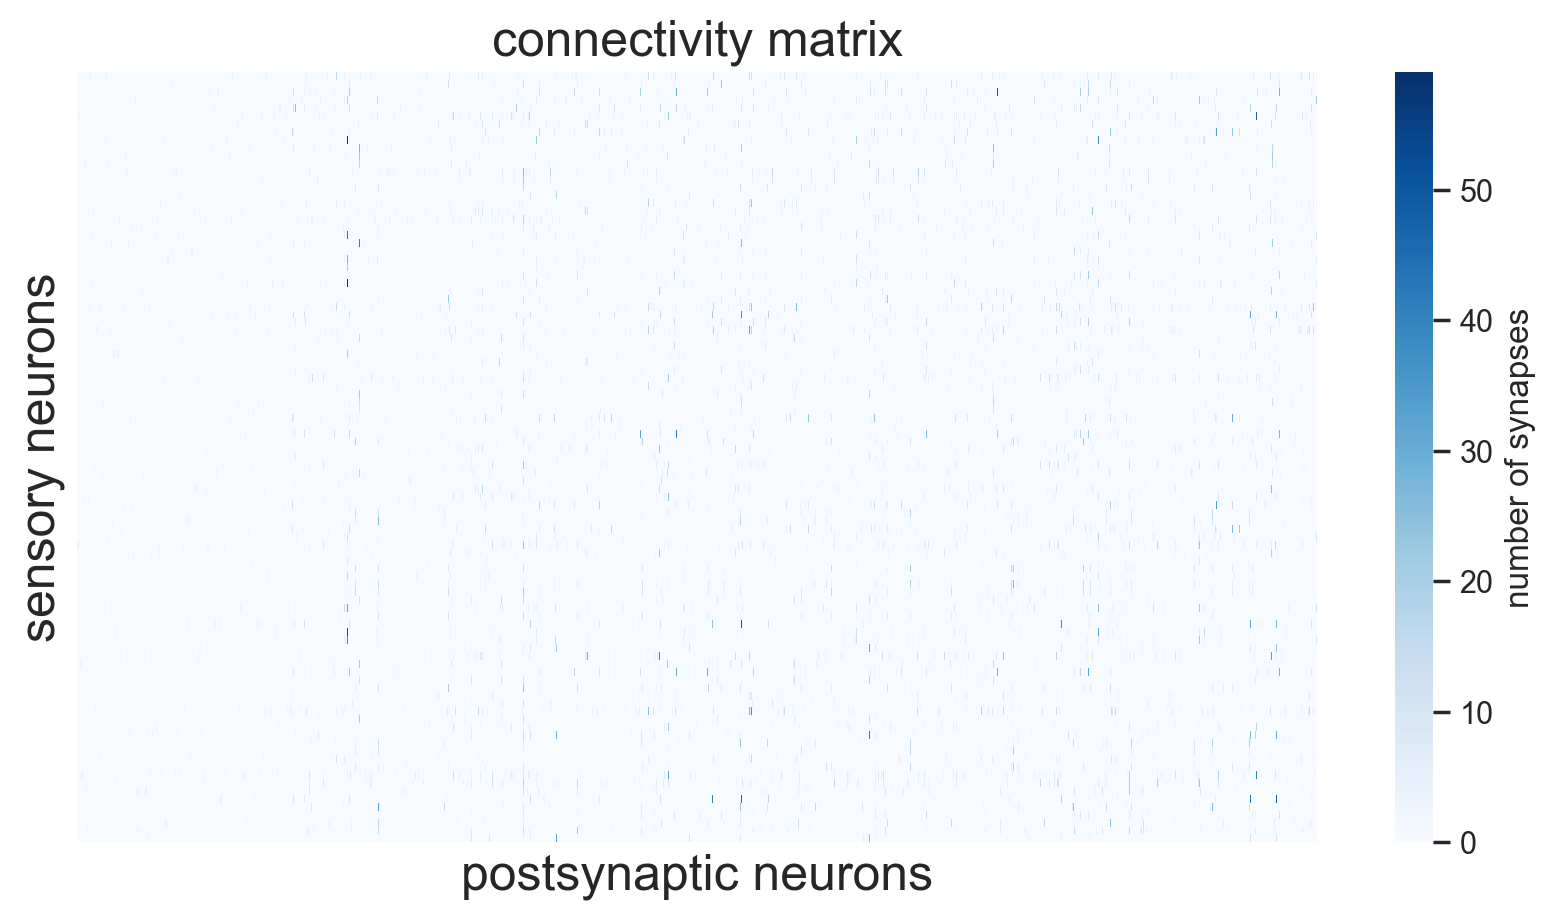

In [10]:
# Plot the connectivity matrix as a heatmap 

sns.set (rc = {'figure.figsize':(10,5)})
sns.heatmap(conn_mat, 
            cmap = 'Blues', 
            xticklabels = [], # turn off the clunky segid labels for now 
            yticklabels = [], 
            cbar_kws={'label': 'number of synapses'})

plt.xlabel('postsynaptic neurons', fontsize = 18)
plt.ylabel('sensory neurons', fontsize = 18)
plt.title('connectivity matrix', fontsize = 18)
plt.rcParams.update({'font.size': 12})
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Annotation Tables
    
Since this is drawing from the raw data, it's hard to make any meaningful inferences. We can reference the annotation tables to get information on the cell types associated with the ids. 

We will be working with two annotation tables: <br> 

**feco_df_all** - contains cell type information for the FeCO sensory axons 
    
**downstream_feco_axons** - contains cell type information for the neurons postsynaptic to FeCO sensory axons
       

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Cell type information 

These annotation tables have a few more columns with cell type information compared to the synapse dataframe. <br><br> 
**cell_type**: <br> 
>feco_df_all: FeCO sensory cell type 
<br>
    
>downstream_feco_axons: hemilineage identity (neurons within a hemilineage share a developmental history and are anatomically similar and release the same neurotransmitter)  
    
    
**classification_system**: <br> 
>feco_df_all: denotes which leg neuropil the sensory axon is in. T1/T2/T3 are the front, middle, or hind legs. L/R are the left or right sides. 
    <br> 

    
>downstream_feco_axons: morphological class of the neuron, either:
>>**ascending**: soma in the VNC, axon ascends to the brain <br> <br> 
**intersegmental**: neuron has axons and dendrite projections that span multiple leg neuropils <br><br>
**local**: neuron is confined to a single leg neuropil <br> <br> 
**MN**: a motor neuron with a cell body and dendrites in the VNC, axon projection exits through a motor nerve to contact muscle fibers <br> <br> 
**sensory**: neuron with a cell body in the periphery and an axon that enters the VNC through a sensory nerve <br> <br> 
    ** note that some neurons can be both ascending and intersegmental <br> 
    
   


In [ ]:
feco_df_all

In [ ]:
downstream_feco_axons

In [11]:
def get_cell_types(idx_input, annotation_table, cell_or_class = 'cell'): 
    
    # inputs: 
#               idx_input: list of segids to reference cell type information 
#               annotation table: table with cell type information for referencing 
#               cell_or_class: 'cell' for referencing cell_type column
#                             'class' for referencing classification_system column 
                    
    # outputs: 
#             cell_type_names: list of cell type names in the same order as the segid input list 

    cell_type_names = [] 
    
    for idx in idx_input: # iterate through segids 
        if idx in annotation_table.pt_root_id.tolist(): 
            if cell_or_class =='cell': 
                cell_type = annotation_table.cell_type[annotation_table.pt_root_id == idx].tolist()[0] # find row that matches the segid and grab cell type name 
                cell_id = annotation_table.id[annotation_table.pt_root_id == idx].tolist()[0] # also grab the cell type id 
                cell_type_names.append(cell_type) # put elements together as a string 
            
            elif cell_or_class == 'class': 
                cell_type_names.append(annotation_table.classification_system[annotation_table.pt_root_id == idx].tolist()[0]) # same as above but references classification_system column 
        else: 
            cell_type_names.append('unknown') # if segid is not in the table, save as unknown 
            
    return cell_type_names

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Referencing annotation tables <br> 
Using the function above, we will: 
    
1. iterate through the pre_pt_root_ids in synapse_df and reference the cell type names from the feco_df_all annotation table 
2. create a new column called "sens_cell_type" in synapse_df and fill with the cell type names 

In [12]:
synapse_df['sens_cell_type'] = get_cell_types(synapse_df.pre_pt_root_id.tolist(), feco_df_all, 'cell')

In [13]:
synapse_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,created,superceded_id,valid,score,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,sens_cell_type
0,0,0,0,12347226,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72553681551362367,648518346508752447,72553681551364124,648518346496052070,[ 15711 104803 3127],[ 15725 104811 3129],claw_ext
1,1,1,1,42127599,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72342781074735265,648518346480125925,72342781074737829,648518346502617767,[ 9275 110693 2403],[ 9251 110663 2404],hook_flx
2,2,2,5,42127607,2022-11-17 14:28:59.843347+00:00,NaN,t,24,72342781074723555,648518346480125925,72342781074721267,648518346489767549,[ 9281 110705 2398],[ 9257 110693 2397],hook_flx
3,3,3,9,42127880,2022-11-17 14:28:59.843347+00:00,NaN,t,19,72342781074677182,648518346480666625,72342781074669821,648518346489566297,[ 9535 110905 2377],[ 9537 110885 2376],hook_flx
4,4,4,10,42127679,2022-11-17 14:28:59.843347+00:00,NaN,t,26,72342781074751920,648518346480125925,72342781074771140,648518346489566297,[ 9325 110663 2408],[ 9323 110625 2409],hook_flx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21911,22315,22315,56524,40344360,2022-11-17 14:28:59.843347+00:00,NaN,t,16,72413149953082217,648518346499722309,72413149953074702,648518346502916595,[ 10875 112293 2636],[ 10839 112307 2636],claw_flx
21912,22316,22316,56526,40514891,2022-11-17 14:28:59.843347+00:00,NaN,t,26,73469299658386692,648518346478788180,73469299658387038,648518346474435437,[ 42003 130737 2820],[ 42027 130751 2819],club_asc
21913,22317,22317,56530,40553999,2022-11-17 14:28:59.843347+00:00,NaN,t,57,72623706563962620,648518346487912272,72623706563955920,648518346490196954,[17855 95375 2861],[17823 95369 2862],claw_ext
21914,22318,22318,56531,40554000,2022-11-17 14:28:59.843347+00:00,NaN,t,46,72623706563962620,648518346487912272,72623706563955958,648518346499593822,[17851 95389 2860],[17821 95399 2860],claw_ext


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Task: 
    
Repeat for the post_pt_root_ids, referencing the classification_system column in the downstream_feco_axons table. Create a new column called "post_cell_type". 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Generate a new connectivity matrix but looking at the connectivity between the sensory cell types and different classifications in the postsynaptic layer. 

Text(92.109375, 0.5, 'sensory neuron')

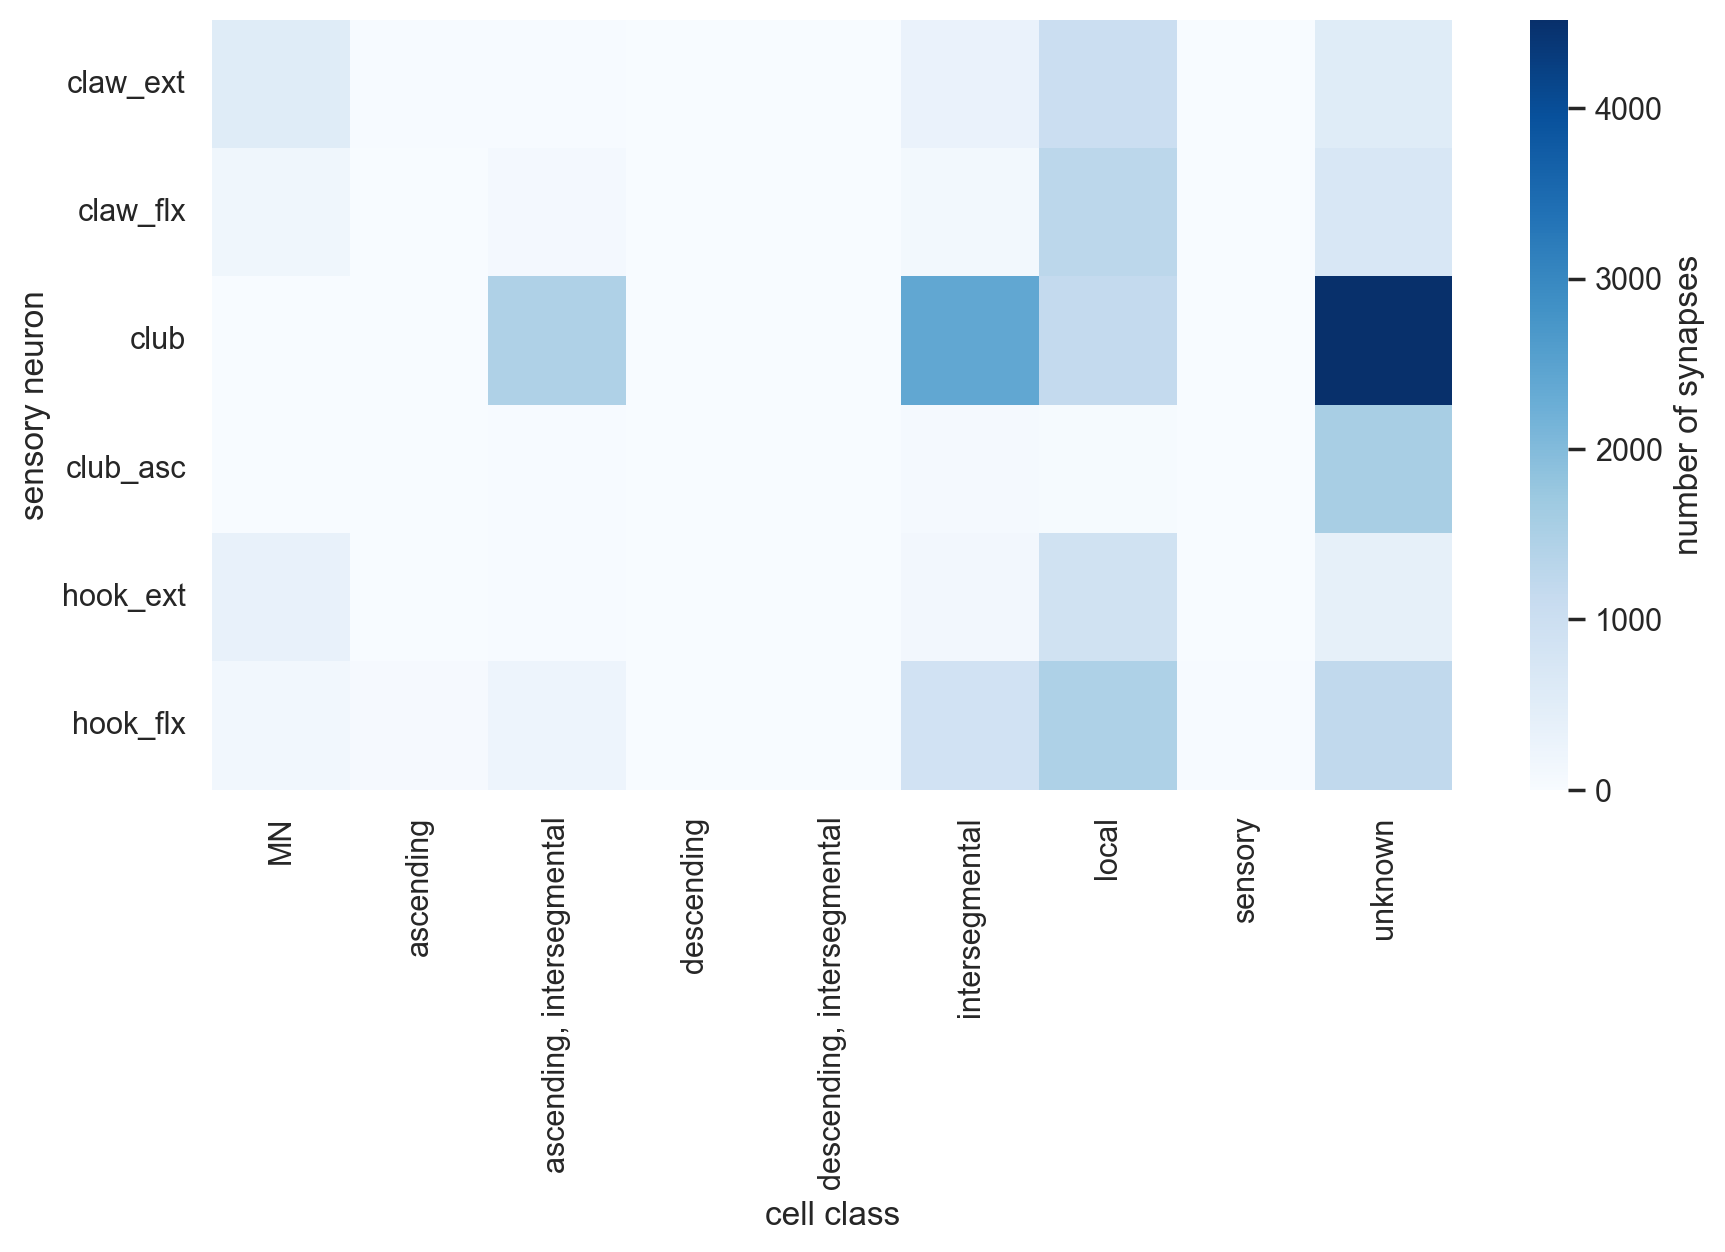

In [31]:
cell_type_adj = pd.crosstab(synapse_df['sens_cell_type'],synapse_df['post_cell_type']) 

sns.heatmap(cell_type_adj, 
            cmap = 'Blues', 
            cbar_kws={'label': 'number of synapses'})
plt.yticks(rotation = 0)
plt.xlabel('cell class')
plt.ylabel('sensory neuron')


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Sensory to motor connections 
    
The FeCO sensory neurons have diverse connectivity patterns. For example, the position and movement tuned neurons (claw and hook) synapse onto motor neurons while the vibration-tuned neurons (club) do not. The position- and movement- tuned (claw and hook) neurons synapse directly onto motor neurons, forming reflexes. The vibration-tuned club neurons, however, do not synapse onto motor neurons. Let's unpack the connectivity between the sensory cell types and motor neurons even further. 

Do the extension-tuned and flexion-tuned neurons synapse onto the same or different sets of motor neurons? 

#### Final Task: Construct a connectivity matrix of sensory neurons and individual motor neurons. Plot as a heatmap. 

1. Reference the cell_type column of the motor neuron annotation table (mn_df) to get the motor neuron cell type names. Save as a new column in synapse_df called 'mn_names'. 
    
2. Construct a connectivity matrix of sensory neurons and individual motor neurons. 
3. Plot as a heat map. 

Text(92.109375, 0.5, 'sensory neuron')

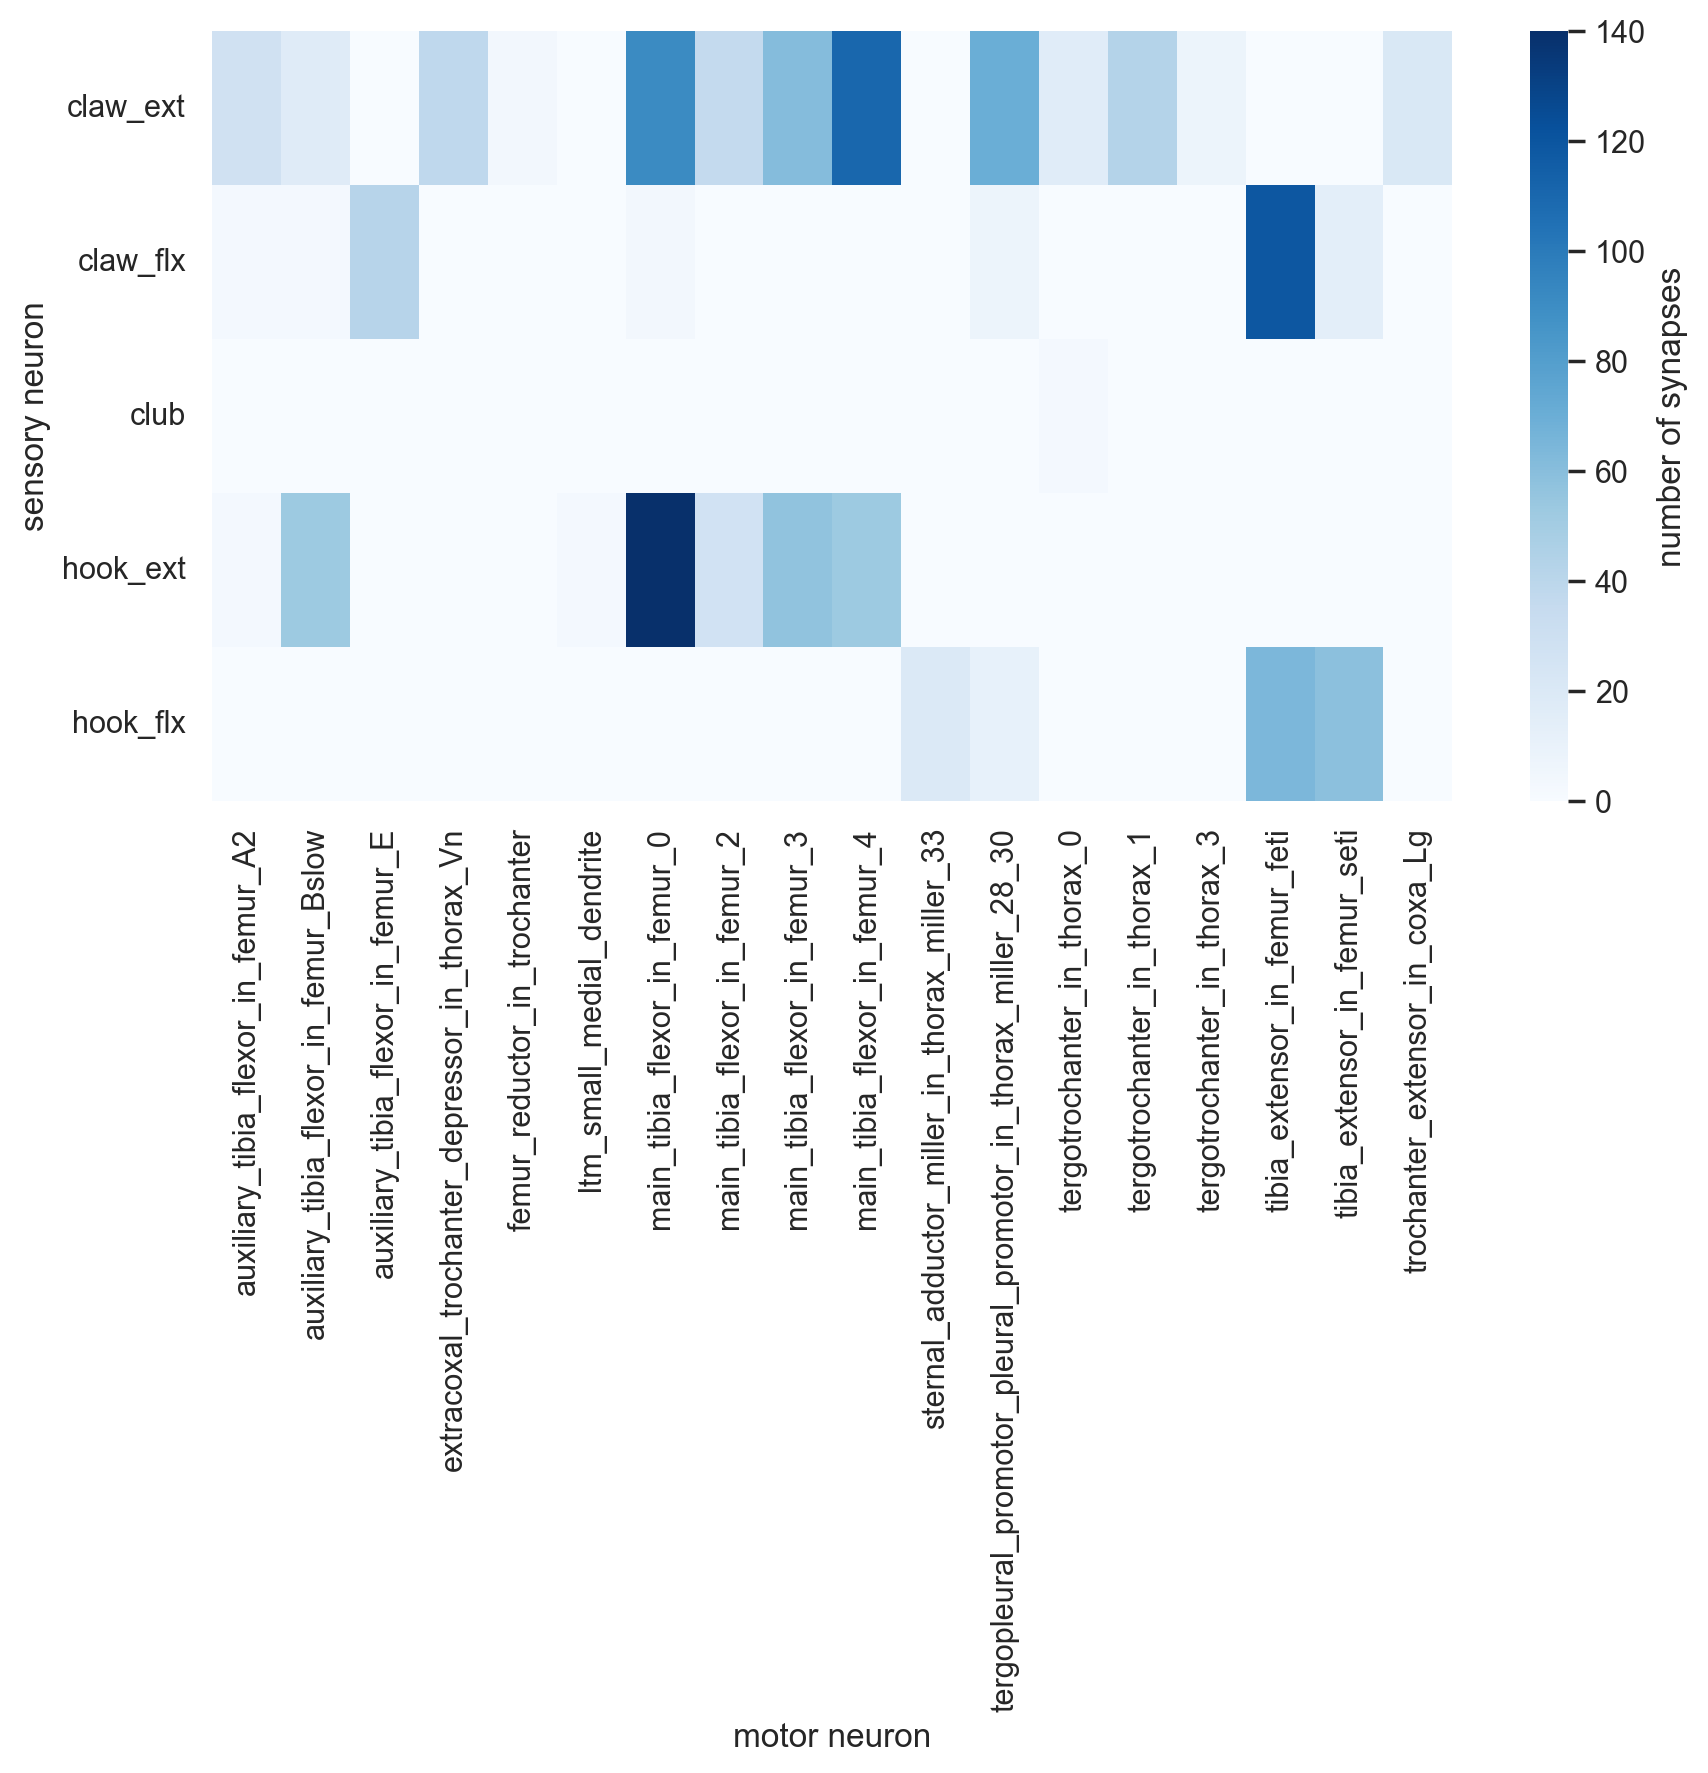

In [30]:
# use get_cell_types to reference the mn_df table to the post_pt_root_ids 
synapse_df['mn_names'] = get_cell_types(synapse_df.post_pt_root_id.tolist(), mn_df)


# construct connectivity matrix between FeCO neurons and MNs 
cell_type_adj = pd.crosstab(synapse_df['sens_cell_type'],synapse_df['mn_names'][synapse_df.post_cell_type == 'MN']) 

sns.heatmap(cell_type_adj, 
            cmap = 'Blues', 
            cbar_kws={'label': 'number of synapses'})
plt.yticks(rotation = 0)
plt.xlabel('motor neuron')
plt.ylabel('sensory neuron')